In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import random 
import matplotlib as mpl
import sklearn 
import datetime
#!pip install xgboost
#!pip install hyperopt
###########for classification#################
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler #Used to scale data. also good idea when doing regularization
from sklearn import metrics
from  sklearn import linear_model, neural_network, ensemble
#!pip install category_encoders
import category_encoders as ce
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval
import hyperopt 
from hyperopt.pyll.stochastic import sample as ho_sample
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve 
##############################################
#set the pd output value
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')

### data description

In [7]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [8]:
df.dtypes

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

In [11]:
df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time', 'DEATH_EVENT'], dtype='object')

In [22]:
#Define target and variables:
target_dummy = 'DEATH_EVENT'
dummy_variables = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']
numerical_variables = ['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine', 'serum_sodium']
all_variables = dummy_variables + numerical_variables

In [17]:
#convert dummy to categorical dtypes
for col in dummy_variables:
    df[col] = df[col].astype('category')
df.dtypes

age                          float64
anaemia                     category
creatinine_phosphokinase       int64
diabetes                    category
ejection_fraction              int64
high_blood_pressure         category
platelets                    float64
serum_creatinine             float64
serum_sodium                   int64
sex                         category
smoking                     category
time                           int64
DEATH_EVENT                    int64
dtype: object

### model training

In [23]:
target = df[target_dummy]
features = df[all_variables]

In [24]:
#Create train and test data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 2, stratify = target)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

#Check if fraction of positive class is similar in train and test
print(np.mean(y_test))
print(np.mean(y_train))

(239, 11)
(60, 11)
(239,)
(60,)
0.31666666666666665
0.32217573221757323


In [18]:
#We scale the data, to get better results. I will not test this, as normally we get better results using scaled data:
min_max_sc = MinMaxScaler()

In [31]:
#############Model 1: Logistic Regression##################
#Because we have unbalanced data, I already pick 'balanced' for class_weight in my base model. No need to test this. For sure
# it will give better results:
lr_basic = LogisticRegression(C = 1, random_state = 100, solver = 'warn', max_iter = 1000)
scale_lr_pipeline = Pipeline(steps = [('scaler', min_max_sc), ('model', lr_basic)])

In [53]:
#################Model 2: Random Forest Classification###################
rfc_basic = RandomForestClassifier()
scale_rf_pipeline = Pipeline(steps = [('scaler', min_max_sc), ('model', rfc_basic)])

In [54]:
#################Model 3: XG Boost############
xgboost_basic = xgb.XGBClassifier()
scale_xg_pipeline = Pipeline(steps = [('scaler', min_max_sc), ('model', xgboost_basic)])

In [55]:
#Encode categorical features
encoder = ce.CatBoostEncoder() 
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.fit_transform(X_test, y_test)

In [56]:
#############################################################
#Run all three base models and get their initial performance:
scale_lr_pipeline.fit(X_train, y_train) #method for random forest classifier) #Logistic Regression
scale_rf_pipeline.fit(X_train, y_train) #Random Forest Classification
scale_xg_pipeline.fit(X_train, y_train) #XG Boost Classification

print(scale_lr_pipeline.score(X_train, y_train))
print(scale_rf_pipeline.score(X_train, y_train))
print(scale_xg_pipeline.score(X_train, y_train))

0.7280334728033473
0.9874476987447699
1.0


C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\

In [57]:
y_pred_proba_lr = scale_lr_pipeline.predict_proba(X_test) #returns the predicted probability 
pos_proba_lr = y_pred_proba_lr[:,1] #array of positive probability
neg_proba_lr = y_pred_proba_lr[:,0] #array of negative probability

y_pred_proba_rf = scale_rf_pipeline.predict_proba(X_test) #returns the predicted probability 
pos_proba_rf = y_pred_proba_rf[:,1] #array of positive probability
neg_proba_rf = y_pred_proba_rf[:,0] #array of negative probability

y_pred_proba_xg = scale_xg_pipeline.predict_proba(X_test) #returns the predicted probability 
pos_proba_xg = y_pred_proba_xg[:,1] #array of positive probability
neg_proba_xg = y_pred_proba_xg[:,0] #array of negative probability

#Get TPR and FPR and threshold values to plot curve:
fpr_basic, tpr_basic, threshold_lr = metrics.roc_curve(y_test, pos_proba_lr, drop_intermediate = False)
fpr_rf, tpr_rf, threshold_rf = metrics.roc_curve(y_test, pos_proba_rf, drop_intermediate = False)
fpr_xg, tpr_xg, threshold_xg = metrics.roc_curve(y_test, pos_proba_xg, drop_intermediate = False)

In [58]:
#ROC AUC Score
print('Logistic regression:', roc_auc_score(y_test, pos_proba_lr))
print('Random Forest Classifier:', roc_auc_score(y_test, pos_proba_rf))
print('XG Boost:', roc_auc_score(y_test, pos_proba_xg))

Logistic regression: 0.8151476251604619
Random Forest Classifier: 0.7439024390243902
XG Boost: 0.72400513478819


Text(0.5, 1.0, 'ROC Curve')

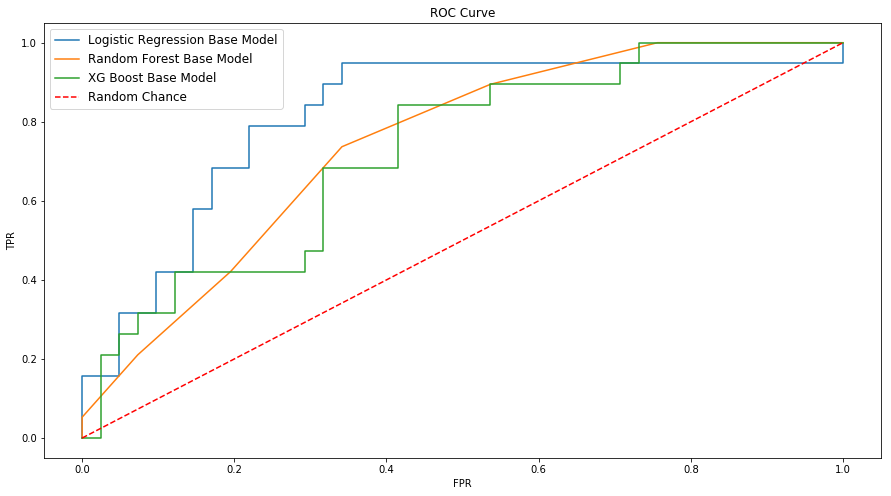

In [59]:
plt.subplots(figsize=(15,8))

plt.plot(fpr_basic, tpr_basic, '')
plt.plot(fpr_rf, tpr_rf, '')
plt.plot(fpr_xg, tpr_xg, '')

plt.plot([0,1],[0,1],'r--')
plt.legend(['Logistic Regression Base Model','Random Forest Base Model','XG Boost Base Model', 'Random Chance', 'Optimized Threshold'], fontsize = 12)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')